<a href="https://colab.research.google.com/github/Mainakdeb/Wine_Quality_Prediction/blob/master/Wine_Connoisseur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn, optim
import torch.nn.functional as F
import tqdm
from tqdm import tnrange

### The Data :

In [41]:
df = pd.read_csv('/content/gdrive/My Drive/Wine_Quality/winequality-red.csv')
df.head()

,"fixed acidity;""volatile acidity"";""citric acid"";""residual sugar"";""chlorides"";""free sulfur dioxide"";""total sulfur dioxide"";""density"";""pH"";""sulphates"";""alcohol"";""quality"""
0,7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
1,7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5
2,7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;...
3,11.2;0.28;0.56;1.9;0.075;17;60;0.998;3.16;0.58...
4,7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5


### Seperate the columns:

In [42]:
split_data = df['fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"'].str.split(";")

data = split_data.to_list()

names = ["Fixed_acidity", "Volatile_acidity", "Citric_acid", "Residual_sugar", "Chlorides", "Free_sulfur_dioxide", "Total_sulfur_Dioxide", "Density", "pH", "Sulphates", "Alcohol", "Quality"]

df2 = pd.DataFrame(data, columns=names)
df2.head()

,Fixed_acidity,Volatile_acidity,Citric_acid,Residual_sugar,Chlorides,Free_sulfur_dioxide,Total_sulfur_Dioxide,Density,pH,Sulphates,Alcohol,Quality
0,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0,2.6,0.098,25,67,0.9968,3.2,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.997,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17,60,0.998,3.16,0.58,9.8,6
4,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5


### Check for null values:

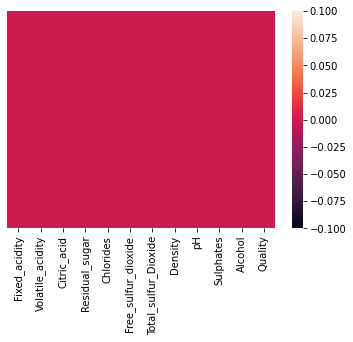

In [43]:
sn.heatmap(df2.isnull(), yticklabels=False)

In [44]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Fixed_acidity         1599 non-null   object
 1   Volatile_acidity      1599 non-null   object
 2   Citric_acid           1599 non-null   object
 3   Residual_sugar        1599 non-null   object
 4   Chlorides             1599 non-null   object
 5   Free_sulfur_dioxide   1599 non-null   object
 6   Total_sulfur_Dioxide  1599 non-null   object
 7   Density               1599 non-null   object
 8   pH                    1599 non-null   object
 9   Sulphates             1599 non-null   object
 10  Alcohol               1599 non-null   object
 11  Quality               1599 non-null   object
dtypes: object(12)
memory usage: 150.0+ KB


### Convert all values into float:

In [0]:
df3 = df2.astype(float)

### Plot Correlation Matrix :

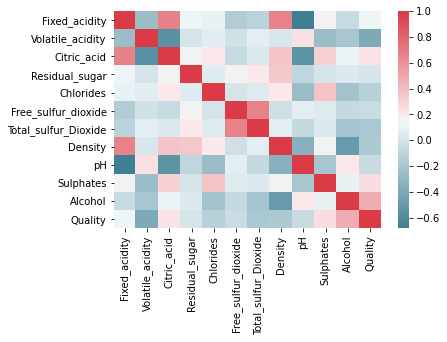

In [46]:
sn.heatmap(df3.corr(), cmap=sn.diverging_palette(220, 10, as_cmap=True))
plt.show()

### A Few More Plots :

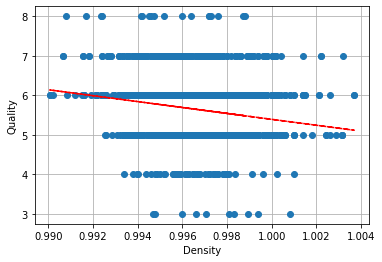

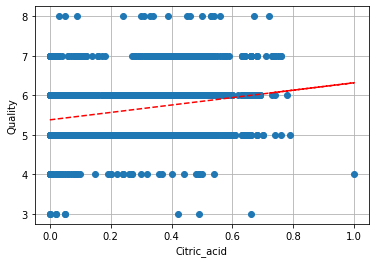

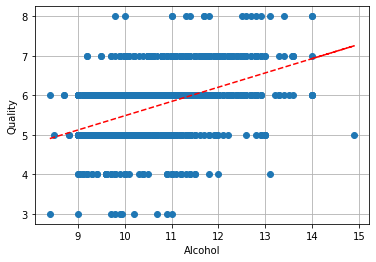

In [74]:
def plot_against_attr(attribute):
    #attribute="Density"
    x = list(df3[attribute])
    y = list(df3['Quality'])
    y, x = zip(*sorted(zip(y, x)))
    plt.plot(x,y,'o')
    plt.xlabel(attribute)
    plt.xticks()
    plt.ylabel('Quality')
    plt.grid()

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.show()
    
plot_against_attr("Density")
plot_against_attr("Citric_acid")
plot_against_attr("Alcohol")

### Scale all values :

In [0]:
quality_backup = df3["Quality"]
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df3), columns = df3.columns)
df_scaled['Quality'] = quality_backup #restore quality values

### Balance Data :

In [114]:
max_size = df_scaled['Quality'].value_counts().max()
lst = [df_scaled]
for class_index, group in df_scaled.groupby('Quality'):
    lst.append(group.sample(max_size-len(group), replace=True))
frame_new = pd.concat(lst)
df_scaled2=frame_new
df_scaled2["Quality"].value_counts()

3.0    681
8.0    681
4.0    681
7.0    681
6.0    681
5.0    681
Name: Quality, dtype: int64

### Shuffle Data :

In [0]:
df_scaled3=df_scaled2.sample(frac=1)

### Split into train, test and val set :

In [0]:
train = df_scaled3.iloc[:3686]
val = df_scaled3.iloc[3686:3886]
test = df_scaled3.iloc[3886:]

### Class distribution in the train-set :

In [52]:
train["Quality"].value_counts()

8.0    630
5.0    620
6.0    619
4.0    612
7.0    603
3.0    602
Name: Quality, dtype: int64

### Split features and labels :

In [53]:
X_train, y_train= train.drop('Quality', axis=1), train['Quality']
print(X_train.shape)

X_val, y_val = val.drop('Quality', axis=1), val['Quality']
print(X_val.shape)

X_test, y_test = test.drop("Quality", axis=1), test["Quality"]

(3686, 11)
(200, 11)


### Split into batches :

In [54]:
f=15 # no. of batches

train_batch = np.array_split(X_train, f) 
label_batch = np.array_split(y_train, f) # 50 sections/batches

val_batch = np.array_split(X_val, f)
val_label_batch = np.array_split(y_val, f)

test_batch = np.array_split(X_test,f) 
test_label_batch  = np.array_split(y_test, f)


for i in range(len(train_batch)):
    train_batch[i] = torch.from_numpy(train_batch[i].values).float()
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1)
    
for i in range(len(val_batch)):
    val_batch[i] = torch.from_numpy(val_batch[i].values).float()
for i in range(len(val_label_batch)):
    val_label_batch[i] = torch.from_numpy(val_label_batch[i].values).float().view(-1, 1)
    
    
for i in range(len(test_batch)):
    test_batch[i] = torch.from_numpy(test_batch[i].values).float()
for i in range(len(test_label_batch)):
    test_label_batch[i] = torch.from_numpy(test_label_batch[i].values).float().view(-1, 1)
    
print("Batch size:", len(train_batch[0]))


Batch size: 246


### The Model :

In [0]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(11, 22)
        self.fc2 = nn.Linear(22, 44)
        self.fc3 = nn.Linear(44, 88)
        self.fc4 = nn.Linear(88, 176)
        self.fc5 = nn.Linear(176, 88)
        self.fc6 = nn.Linear(88, 22)
        self.fc7 = nn.Linear(22, 1)
       
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))

        return x

model = Regressor()
train_losses, val_losses = [], []
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) # 0.015 87
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.1, patience=15) 
total_epochs=0

### The training loop :

In [0]:
#print(model)
epochs = 1000
total_epochs+=epochs

for e in tnrange(epochs):
    
    model.train()
    train_loss = 0
    val_loss_1=0
    val_loss_sum = 0
    
    for i in range(len(train_batch)):
        
        optimizer.zero_grad()
        output = model(train_batch[i])
        loss = criterion(output, label_batch[i])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
        with torch.no_grad():
            
            for j in range(len(val_batch)):
                
                val_output = model(val_batch[j])
                val_loss =  criterion(val_output, val_label_batch[j])
                val_loss_1+=val_loss.item()
        val_loss_sum=val_loss_1/len(val_batch)
        
        
    print("Epoch :", e, "train_loss :", train_loss/len(train_batch), "Val loss: ", val_loss_sum/len(val_batch))    
    val_losses.append(val_loss_sum/len(val_batch))    
    train_losses.append(train_loss/len(train_batch))   

### Training Metrics :

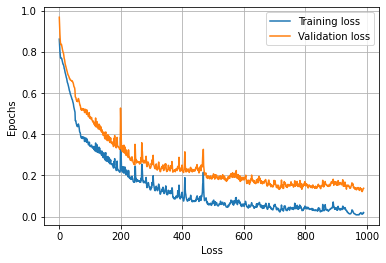

In [73]:
frm=10 # does not 
plt.plot(train_losses[frm:], label='Training loss')
plt.plot(val_losses[frm:], label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

### Save and load the model :

In [0]:
torch.save(model.state_dict(), '/content/gdrive/My Drive/Wine_Quality/model_93.pt')


In [70]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/Wine_Quality/model_93.pt'))

<All keys matched successfully>

### How does the model perform on the test-set?

In [72]:
correct=0
i=0
res=[]
with torch.no_grad():
    for batch in test_batch :
        for j in range(len(batch)):
            x = model(batch[j])
            #print(round(x.item()))
            res.append(round(x.item()))

true_labels= list(test["Quality"])

for i in range(len(res)):
    if res[i]==int(true_labels[i]):
        correct+=1
        
print("Accuracy:", 100*(correct/len(res)), "%")

Accuracy: 93.0 %
